In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.interpolate import  interp1d
import statsmodels.api as sm

lowess = sm.nonparametric.lowess

plt.rcParams['axes.linewidth']=1.5

In [2]:
# Load data
dx = pd.read_csv('Data/MeiklejohnC.csv')
df = pd.read_csv('Data/MeiklejohnCa.csv')

# Remove samples that do not have d44Ca values, store as df_ca
df_ca = df.dropna(subset=['d44Ca'])
df_srca = df.dropna(subset=['Sr/Ca'])

d13C = dx['d13c'].to_numpy()
meter_c = dx['Meter'].to_numpy()
d44Ca = df_ca['d44Ca'].to_numpy()
meter_ca = df_ca['Meterage'].to_numpy()

SrCa_data = df_srca['Sr/Ca'].to_numpy()
meter_srca = df_srca['Meterage'].to_numpy()

In [3]:
# Aragonite fractionation (Romanek et al., 1992)
Darg = 2.7

# Calcite fractionation (Romanek et al., 1992)
Dcalc = 1.0

# Aragonite and Calcite mixing model
def mixing(farg, darg=2.7, dcalc=1.0, DIC=0):
    """Isotopic mixing model

    Simplified two endmembers mixing models.

    Parameters
    ----------
    farg : ndarray
        Aragonite fraction.
    darg : float, optional
        Aragonite fractionation factor. Default is +2.7permil.
    dcalc : float, optional
        Calcite fractionation factor. Default is +1permil.
    DIC : float, optional
        Isotopic ratio of DIC from which aragonite and calcite
        precipitate. Default is 0permil.
    
    Returns
    -------
    d13Ccarb : float
        Isotopic ratio of bulk rock (mixed of aragonite + calcite).
    """
    fcalc = (1 - farg)
    d13Carg = DIC + darg
    d13Ccalc = DIC + dcalc
    d13Ccarb = farg*d13Carg + fcalc*d13Ccalc
    return d13Ccarb

def cmixing(farg, carg, ccalc):
    """Concentration mixing model

    Parameters
    ----------
    farg : ndarray
        Aragonite fraction.
    carg : float 
        Concentration of element in aragonite.
    ccalc : float, optional
        Concentration of element in calcite.
    
    Returns
    -------
    mix : float
        Concentration of element in the mixture / bulk carbonate.
    """
    fcalc = (1 - farg)
    mix = farg*carg + fcalc*ccalc
    return mix

def isomixing(farg, carg, ccalc,darg=2.7, dcalc=1.0, DIC=0):
    """Isotopic mixing model

    Simplified two endmembers mixing models.

    Parameters
    ----------
    farg : ndarray
        Aragonite fraction.
    carg : float 
        Concentration of element in aragonite.
    ccalc : float, optional
        Concentration of element in calcite.
    darg : float, optional
        Aragonite fractionation factor. Default is +2.7permil.
    dcalc : float, optional
        Calcite fractionation factor. Default is +1permil.
    DIC : float, optional
        Isotopic ratio of DIC from which aragonite and calcite
        precipitate. Default is 0permil.
    
    Returns
    -------
    d13Ccarb : float
        Isotopic ratio of bulk rock (mixed of aragonite + calcite).
    """
    cmix = cmixing(farg, carg, ccalc)
    fcalc = (1 - farg)
    d13Carg = DIC + darg
    d13Ccalc = DIC + dcalc
    d13Ccarb = farg*(carg/cmix)*d13Carg + fcalc*(ccalc/cmix)*d13Ccalc
    return d13Ccarb

In [4]:
farg = np.linspace(0, 1, 5)
carb = mixing(farg, DIC=-3.7)

In [5]:
Cacarb = mixing(farg, darg=-1.5, dcalc=-0.9)

In [6]:
# Concentration in ppm
Ca_calcite = 400551
Sr_calcite = 500

# Concentration in ppm
Ca_aragonite = 397120
Sr_aragonite = 8000

Calccarb = cmixing(farg, Ca_aragonite, Ca_calcite)
Srcarb = cmixing(farg, Sr_aragonite, Sr_calcite)

SrCa = Srcarb / Calccarb * (40.078/97.62) * 1000

In [7]:
# Concentration in percent
C_calcite = 43.97
C_aragonite = 40

isocarb = isomixing(farg, C_aragonite, C_calcite, DIC=-3.7)
isoCacarb = isomixing(farg, C_aragonite, C_calcite, darg=-1.6, dcalc=-0.9)

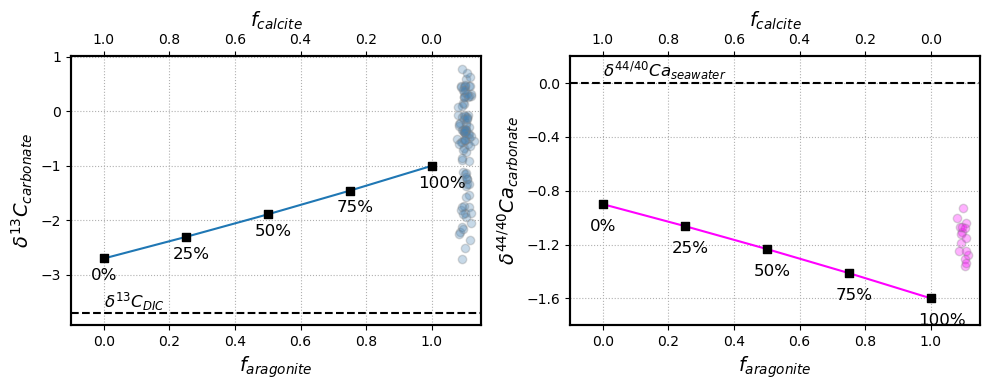

In [8]:
# Generate random x positions around 1.1 to plot data
rng = np.random.default_rng(614)
xdum1 = rng.normal(1.1, 0.01, len(d13C))
xdum2 = rng.normal(1.1, 0.01, len(d44Ca))
xdum3 = rng.normal(1.1, 0.01, len(SrCa_data))

fig, (ax,ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.plot(farg, isocarb)
ax.scatter(farg, isocarb, fc='k', marker='s', zorder=5)
ax.scatter(xdum1, d13C, fc='steelblue', ec='grey', alpha=0.3)
ax.axhline(y=-3.7, ls='--', c='k')
for i, j in zip(farg,isocarb):
    dx, dy = -0.04, -0.4
    ax.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)

ax.text(0, -3.6, '$\delta^{13}C_{DIC}$', fontsize=12)
ax.set_xlabel('$f_{aragonite}$', fontsize=14)
ax.set_ylabel('$\delta^{13}C_{carbonate}$', fontsize=14)
# ax.set_ylim(-0.4, 2.9)
ax.set_xlim(-0.1, 1.15)

axt = ax.twiny()
axt.set_xlim(1-(-0.1), 1-1.15)
axt.set_xlabel('$f_{calcite}$', fontsize=14)


ax1.plot(farg, isoCacarb, c='magenta')
ax1.scatter(farg, isoCacarb, fc='k', marker='s', zorder=5)
ax1.scatter(xdum2, d44Ca, fc='magenta', ec='grey', alpha=0.3)
ax1.axhline(y=0, ls='--', c='k')
for i, j in zip(farg,isoCacarb):
    dx, dy = -0.04, -0.2
    ax1.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)

ax1.text(0, 0.05, '$\delta^{44/40}Ca_{seawater}$', fontsize=12)
ax1.set_xlabel('$f_{aragonite}$', fontsize=14)
ax1.set_ylabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax1.set_ylim(-1.8, 0.2)
ax1.set_xlim(-0.1, 1.15)

for ax in [ax, ax1]:
    ax.grid(which='both', linestyle=':')
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

axt1 = ax1.twiny()
axt1.set_xlim(1-(-0.1), 1-1.15)
axt1.set_xlabel('$f_{calcite}$', fontsize=14)

plt.tight_layout()
# plt.savefig('Figure/Aragonite_CalciteMixing.png', dpi=300)

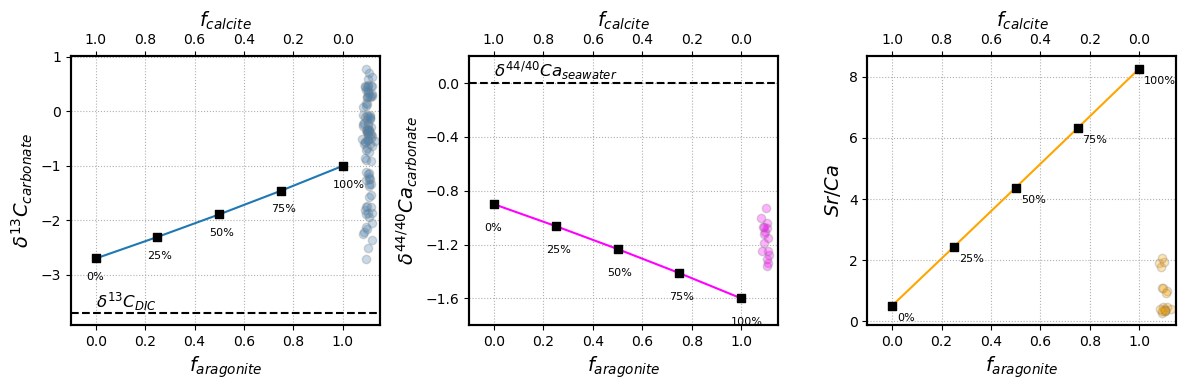

In [9]:
fig, (ax, ax1, ax2)  = plt.subplots(1, 3, figsize=(12, 4))



ax.plot(farg, isocarb)
ax.scatter(farg, isocarb, fc='k', marker='s', zorder=5)
ax.scatter(xdum1, d13C, fc='steelblue', ec='grey', alpha=0.3)
ax.axhline(y=-3.7, ls='--', c='k')
for i, j in zip(farg,isocarb):
    dx, dy = -0.04, -0.4
    ax.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=8)

ax.text(0, -3.6, '$\delta^{13}C_{DIC}$', fontsize=12)
ax.set_xlabel('$f_{aragonite}$', fontsize=14)
ax.set_ylabel('$\delta^{13}C_{carbonate}$', fontsize=14)
# ax.set_ylim(-0.4, 2.9)
ax.set_xlim(-0.1, 1.15)

axt = ax.twiny()
axt.set_xlim(1-(-0.1), 1-1.15)
axt.set_xlabel('$f_{calcite}$', fontsize=14)


ax1.plot(farg, isoCacarb, c='magenta')
ax1.scatter(farg, isoCacarb, fc='k', marker='s', zorder=5)
ax1.scatter(xdum2, d44Ca, fc='magenta', ec='grey', alpha=0.3)
ax1.axhline(y=0, ls='--', c='k')
for i, j in zip(farg,isoCacarb):
    dx, dy = -0.04, -0.2
    ax1.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=8)

ax1.text(0, 0.05, '$\delta^{44/40}Ca_{seawater}$', fontsize=12)
ax1.set_xlabel('$f_{aragonite}$', fontsize=14)
ax1.set_ylabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax1.set_ylim(-1.8, 0.2)
ax1.set_xlim(-0.1, 1.15)

axt1 = ax1.twiny()
axt1.set_xlim(1-(-0.1), 1-1.15)
axt1.set_xlabel('$f_{calcite}$', fontsize=14)

ax2.plot(farg, SrCa, c='orange')
ax2.scatter(farg, SrCa, fc='k', marker='s', zorder=5)
ax2.scatter(xdum3, SrCa_data, fc='orange', ec='grey', alpha=0.3)

for i, j in zip(farg,SrCa):
    dx, dy = 0.02, -0.5
    ax2.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=8)


ax2.set_xlabel('$f_{aragonite}$', fontsize=14)
ax2.set_ylabel('$Sr/Ca$', fontsize=14)

ax2.set_xlim(-0.1, 1.15)

axt2 = ax2.twiny()
axt2.set_xlim(1-(-0.1), 1-1.15)
axt2.set_xlabel('$f_{calcite}$', fontsize=14)


for ax in [ax, ax1, ax2]:
    ax.grid(which='both', linestyle=':')
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
# plt.savefig('Figure/Aragonite_CalciteMixing_all.png', dpi=300)

In [10]:
def subplots_centered(nrows, ncols, figsize, nfigs):
    """
    Modification of matplotlib plt.subplots(),
    useful when some subplots are empty.
    
    It returns a grid where the plots
    in the **last** row are centered.
    
    Inputs
    ------
        nrows, ncols, figsize: same as plt.subplots()
        nfigs: real number of figures
    """
    assert nfigs < nrows * ncols, "No empty subplots, use normal plt.subplots() instead"
    
    fig = plt.figure(figsize=figsize)
    axs = []
    
    m = nfigs % ncols
    m = range(1, ncols+1)[-m]  # subdivision of columns
    gs = gridspec.GridSpec(nrows, m*ncols)

    for i in range(0, nfigs):
        row = i // ncols
        col = i % ncols

        if row == nrows-1: # center only last row
            off = int(m * (ncols - nfigs % ncols) / 2)
        else:
            off = 0

        ax = plt.subplot(gs[row, m*col + off : m*(col+1) + off])
        axs.append(ax)
        
    return fig, axs

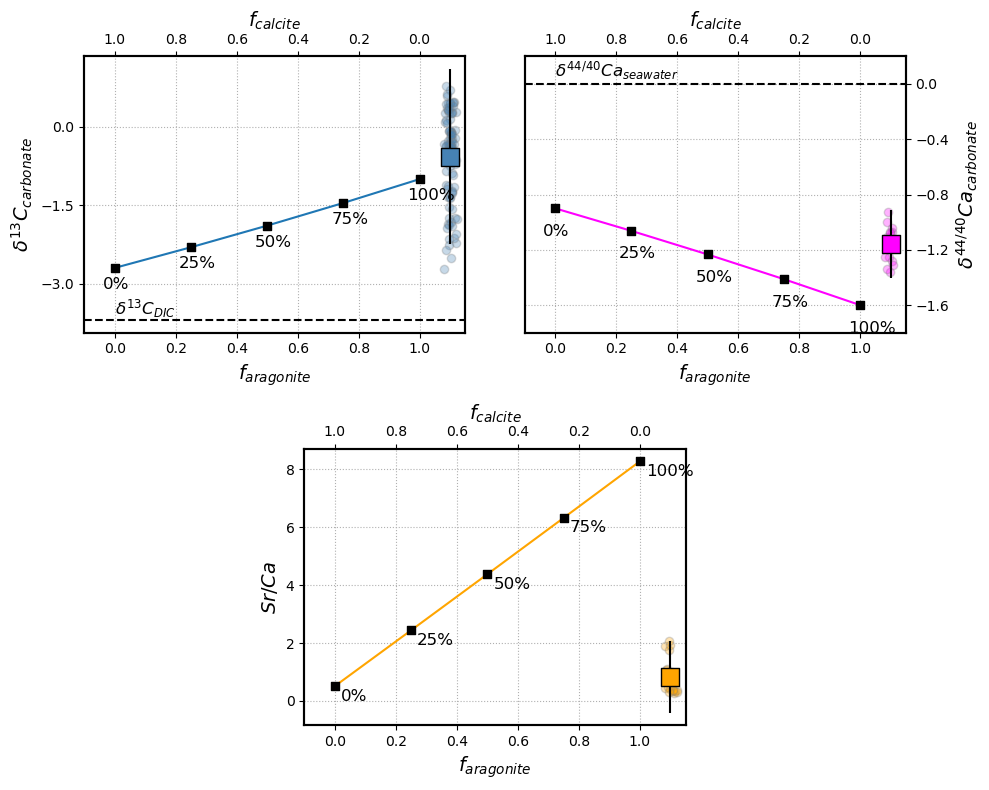

In [11]:
fig, axs = subplots_centered(nrows=2, ncols=2, figsize=(10,8), nfigs=3)

ax = axs[0]
ax1 = axs[1]
ax2 = axs[2]

# Generate random x positions around 1.1 to plot data
xdum1 = rng.normal(1.1, 0.01, len(d13C))
xdum2 = rng.normal(1.1, 0.01, len(d44Ca))
xdum3 = rng.normal(1.1, 0.01, len(SrCa_data))

ax.plot(farg, isocarb)
ax.scatter(farg, isocarb, fc='k', marker='s', zorder=5)
ax.scatter(xdum1, d13C, fc='steelblue', ec='grey', alpha=0.3)
ax.axhline(y=-3.7, ls='--', c='k')
for i, j in zip(farg,isocarb):
    dx, dy = -0.04, -0.4
    ax.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)

ax.text(0, -3.6, '$\delta^{13}C_{DIC}$', fontsize=12)
ax.set_xlabel('$f_{aragonite}$', fontsize=14)
ax.set_ylabel('$\delta^{13}C_{carbonate}$', fontsize=14)
# ax.set_ylim(-0.4, 2.9)
ax.set_xlim(-0.1, 1.15)

axt = ax.twiny()
axt.set_xlim(1-(-0.1), 1-1.15)
axt.set_xlabel('$f_{calcite}$', fontsize=14)

# --------------
ax1.plot(farg, isoCacarb, c='magenta')
ax1.scatter(farg, isoCacarb, fc='k', marker='s', zorder=5)
ax1.scatter(xdum2, d44Ca, fc='magenta', ec='grey', alpha=0.3)
ax1.axhline(y=0, ls='--', c='k')
for i, j in zip(farg,isoCacarb):
    dx, dy = -0.04, -0.2
    ax1.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)

ax1.text(0, 0.05, '$\delta^{44/40}Ca_{seawater}$', fontsize=12)
ax1.set_xlabel('$f_{aragonite}$', fontsize=14)
ax1.set_ylabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax1.set_ylim(-1.8, 0.2)
ax1.set_xlim(-0.1, 1.15)
ax1.tick_params(axis='y', left=False, right=True, labelleft=False,
                labelright=True)
ax1.yaxis.set_label_position('right')

axt1 = ax1.twiny()
axt1.set_xlim(1-(-0.1), 1-1.15)
axt1.set_xlabel('$f_{calcite}$', fontsize=14)

#-----------------
ax2.plot(farg, SrCa, c='orange')
ax2.scatter(farg, SrCa, fc='k', marker='s', zorder=5)
ax2.scatter(xdum3, SrCa_data, fc='orange', ec='grey', alpha=0.3)

for i, j in zip(farg,SrCa):
    dx, dy = 0.02, -0.5
    ax2.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)


ax2.set_xlabel('$f_{aragonite}$', fontsize=14)
ax2.set_ylabel('$Sr/Ca$', fontsize=14)

ax2.set_xlim(-0.1, 1.15)

axt2 = ax2.twiny()
axt2.set_xlim(1-(-0.1), 1-1.15)
axt2.set_xlabel('$f_{calcite}$', fontsize=14)


for axo in [ax, ax1, ax2]:
    axo.grid(which='both', linestyle=':')
    axo.yaxis.set_major_locator(plt.MaxNLocator(5))

ax.scatter(1.1, np.mean(d13C), s=150, marker='s',fc='steelblue', ec='k', zorder=5)
ax.errorbar(1.1, np.mean(d13C), yerr=2*np.std(d13C), c='black', zorder=4)

ax1.scatter(1.1, np.mean(d44Ca), s=150, marker='s',fc='magenta', ec='k', zorder=5)
ax1.errorbar(1.1, np.mean(d44Ca), yerr=2*np.std(d44Ca), c='black', zorder=4)

ax2.scatter(1.1, np.mean(SrCa_data), s=150, marker='s',fc='orange', ec='k', zorder=5)
ax2.errorbar(1.1, np.mean(SrCa_data), yerr=2*np.std(SrCa_data), c='black', zorder=4)

plt.tight_layout()
# plt.savefig('Figure/Aragonite_CalciteMixing_all_stacked.png', dpi=300)

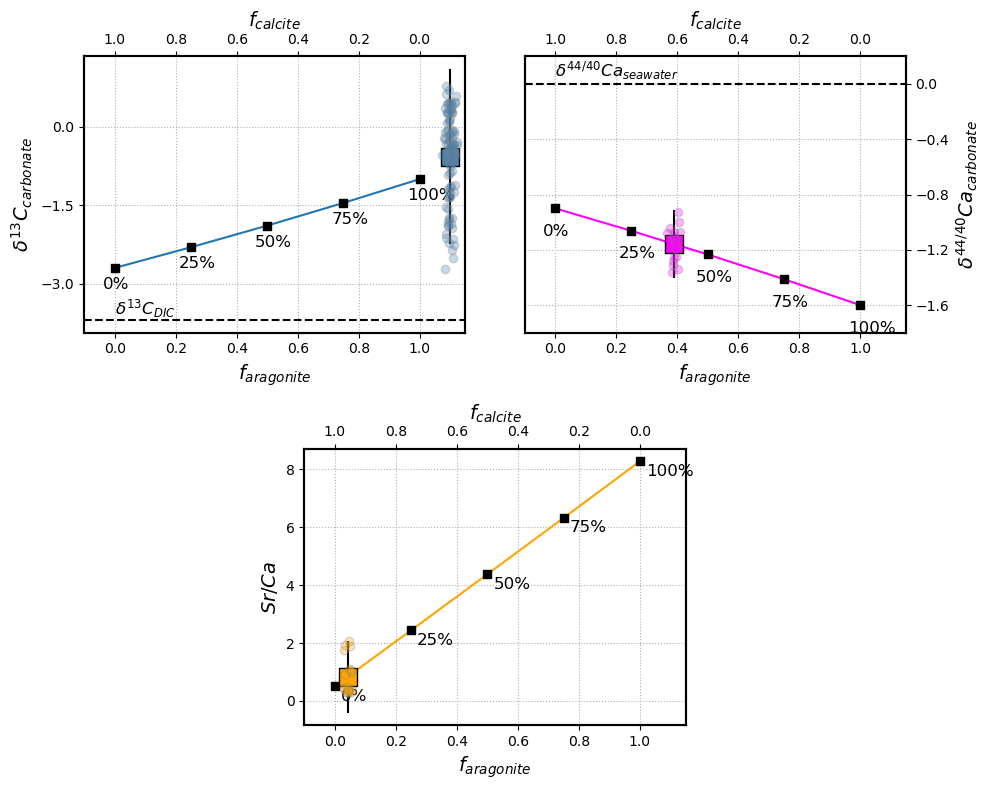

In [12]:
fig, axs = subplots_centered(nrows=2, ncols=2, figsize=(10,8), nfigs=3)

ax = axs[0]
ax1 = axs[1]
ax2 = axs[2]

# Generate random x positions around 1.1 to plot data
xdum1 = rng.normal(1.1, 0.01, len(d13C))

fca = interp1d(isoCacarb, farg)
fargca = fca(np.mean(d44Ca))
# Generate random x positions around mean d44Ca to plot data
xdum2 = rng.normal(fargca, 0.01, len(d44Ca))

fsrca = interp1d(SrCa, farg)
fargsrca = fsrca(np.mean(SrCa_data))
# Generate random x positions around mean Sr/Ca to plot data
xdum3 = rng.normal(fargsrca, 0.01, len(SrCa_data))

ax.plot(farg, isocarb)
ax.scatter(farg, isocarb, fc='k', marker='s', zorder=5)
ax.scatter(xdum1, d13C, fc='steelblue', ec='grey', alpha=0.3, zorder=6)
ax.axhline(y=-3.7, ls='--', c='k')
for i, j in zip(farg,isocarb):
    dx, dy = -0.04, -0.4
    ax.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)

ax.text(0, -3.6, '$\delta^{13}C_{DIC}$', fontsize=12)
ax.set_xlabel('$f_{aragonite}$', fontsize=14)
ax.set_ylabel('$\delta^{13}C_{carbonate}$', fontsize=14)
# ax.set_ylim(-0.4, 2.9)
ax.set_xlim(-0.1, 1.15)

axt = ax.twiny()
axt.set_xlim(1-(-0.1), 1-1.15)
axt.set_xlabel('$f_{calcite}$', fontsize=14)

# --------------
ax1.plot(farg, isoCacarb, c='magenta')
ax1.scatter(farg, isoCacarb, fc='k', marker='s', zorder=5)
ax1.scatter(xdum2, d44Ca, fc='magenta', ec='grey', alpha=0.3, zorder=6)
ax1.axhline(y=0, ls='--', c='k')
for i, j in zip(farg,isoCacarb):
    dx, dy = -0.04, -0.2
    ax1.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)

ax1.text(0, 0.05, '$\delta^{44/40}Ca_{seawater}$', fontsize=12)
ax1.set_xlabel('$f_{aragonite}$', fontsize=14)
ax1.set_ylabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax1.set_ylim(-1.8, 0.2)
ax1.set_xlim(-0.1, 1.15)
ax1.tick_params(axis='y', left=False, right=True, labelleft=False,
                labelright=True)
ax1.yaxis.set_label_position('right')

axt1 = ax1.twiny()
axt1.set_xlim(1-(-0.1), 1-1.15)
axt1.set_xlabel('$f_{calcite}$', fontsize=14)

#-----------------
ax2.plot(farg, SrCa, c='orange')
ax2.scatter(farg, SrCa, fc='k', marker='s', zorder=5)
ax2.scatter(xdum3, SrCa_data, fc='orange', ec='grey', alpha=0.3, zorder=6)

for i, j in zip(farg,SrCa):
    dx, dy = 0.02, -0.5
    ax2.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)


ax2.set_xlabel('$f_{aragonite}$', fontsize=14)
ax2.set_ylabel('$Sr/Ca$', fontsize=14)

ax2.set_xlim(-0.1, 1.15)

axt2 = ax2.twiny()
axt2.set_xlim(1-(-0.1), 1-1.15)
axt2.set_xlabel('$f_{calcite}$', fontsize=14)


for axo in [ax, ax1, ax2]:
    axo.grid(which='both', linestyle=':')
    axo.yaxis.set_major_locator(plt.MaxNLocator(5))

ax.scatter(1.1, np.mean(d13C), s=150, marker='s',fc='steelblue', ec='k', zorder=5)
ax.errorbar(1.1, np.mean(d13C), yerr=2*np.std(d13C), c='black', zorder=4)

ax1.scatter(fargca, np.mean(d44Ca), s=150, marker='s',fc='magenta', ec='k', zorder=5)
ax1.errorbar(fargca, np.mean(d44Ca), yerr=2*np.std(d44Ca), c='black', zorder=4)

ax2.scatter(fargsrca, np.mean(SrCa_data), s=150, marker='s',fc='orange', ec='k', zorder=5)
ax2.errorbar(fargsrca, np.mean(SrCa_data), yerr=2*np.std(SrCa_data), c='black', zorder=4)

plt.tight_layout()
# plt.savefig('Figure/Aragonite_CalciteMixing_ontheline_all_stacked.png', dpi=300)
# plt.savefig('Figure/Aragonite_CalciteMixing_ontheline_all_stacked.svg')

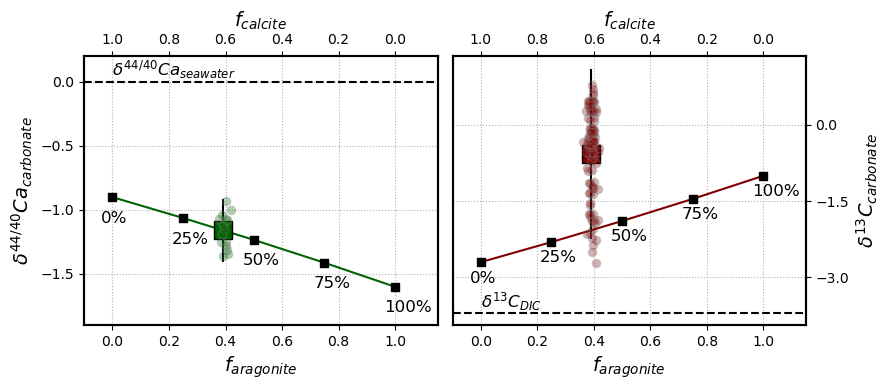

In [13]:
fig, (ax1, ax)  = plt.subplots(1, 2, figsize=(9, 4))

# Generate random x positions around 1.1 to plot data
xdum1 = rng.normal(fargca, 0.01, len(d13C))

fca = interp1d(isoCacarb, farg)
fargca = fca(np.mean(d44Ca))
# Generate random x positions around mean d44Ca to plot data
xdum2 = rng.normal(fargca, 0.01, len(d44Ca))

fsrca = interp1d(SrCa, farg)
fargsrca = fsrca(np.mean(SrCa_data))
# Generate random x positions around mean Sr/Ca to plot data
xdum3 = rng.normal(fargsrca, 0.01, len(SrCa_data))

ax.plot(farg, isocarb, c='maroon')
ax.scatter(farg, isocarb, fc='k', marker='s', zorder=5)
ax.scatter(xdum1, d13C, fc='maroon', ec='grey', alpha=0.3, zorder=6)
ax.axhline(y=-3.7, ls='--', c='k')
for i, j in zip(farg,isocarb):
    dx, dy = -0.04, -0.4
    ax.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)

ax.text(0, -3.6, '$\delta^{13}C_{DIC}$', fontsize=12)
ax.set_xlabel('$f_{aragonite}$', fontsize=14)
ax.set_ylabel('$\delta^{13}C_{carbonate}$', fontsize=14)
# ax.set_ylim(-0.4, 2.9)
ax.set_xlim(-0.1, 1.15)

ax.tick_params(axis='y', left=False, right=True, labelleft=False,
                labelright=True)
ax.yaxis.set_label_position('right')

axt = ax.twiny()
axt.set_xlim(1-(-0.1), 1-1.15)
axt.set_xlabel('$f_{calcite}$', fontsize=14)

# --------------
ax1.plot(farg, isoCacarb, c='darkgreen')
ax1.scatter(farg, isoCacarb, fc='k', marker='s', zorder=5)
ax1.scatter(xdum2, d44Ca, fc='darkgreen', ec='grey', alpha=0.3, zorder=6)
ax1.axhline(y=0, ls='--', c='k')
for i, j in zip(farg,isoCacarb):
    dx, dy = -0.04, -0.2
    ax1.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)

ax1.text(0, 0.05, '$\delta^{44/40}Ca_{seawater}$', fontsize=12)
ax1.set_xlabel('$f_{aragonite}$', fontsize=14)
ax1.set_ylabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax1.set_ylim(-1.9, 0.2)
ax1.set_xlim(-0.1, 1.15)


axt1 = ax1.twiny()
axt1.set_xlim(1-(-0.1), 1-1.15)
axt1.set_xlabel('$f_{calcite}$', fontsize=14)

for axo in [ax, ax1]:
    axo.grid(which='both', linestyle=':')
    axo.yaxis.set_major_locator(plt.MaxNLocator(5))

ax.scatter(fargca, np.mean(d13C), s=150, marker='s',fc='maroon', ec='k', zorder=5)
ax.errorbar(fargca, np.mean(d13C), yerr=2*np.std(d13C), c='black', zorder=4)

ax1.scatter(fargca, np.mean(d44Ca), s=150, marker='s',fc='darkgreen', ec='k', zorder=5)
ax1.errorbar(fargca, np.mean(d44Ca), yerr=2*np.std(d44Ca), c='black', zorder=4)


plt.tight_layout()
plt.savefig('Figure/Aragonite_CalciteMixing_ontheline_CnCa.png', dpi=300)
plt.savefig('Figure/Aragonite_CalciteMixing_ontheline_CnCa.svg')

In [14]:
fca = interp1d(isoCacarb, farg, fill_value='extrapolate')
fsrca = interp1d(SrCa, farg, bounds_error=False, fill_value='extrapolate')

# Aragonite and Calcite fraction from Ca isotope
frac_arag_ca = fca(d44Ca)
frac_calc_ca = 1 - frac_arag_ca

# Aragonite and Calcite fraction from Sr/Ca
frac_arag_srca = fsrca(SrCa_data)
frac_calc_srca = 1 - frac_arag_ca

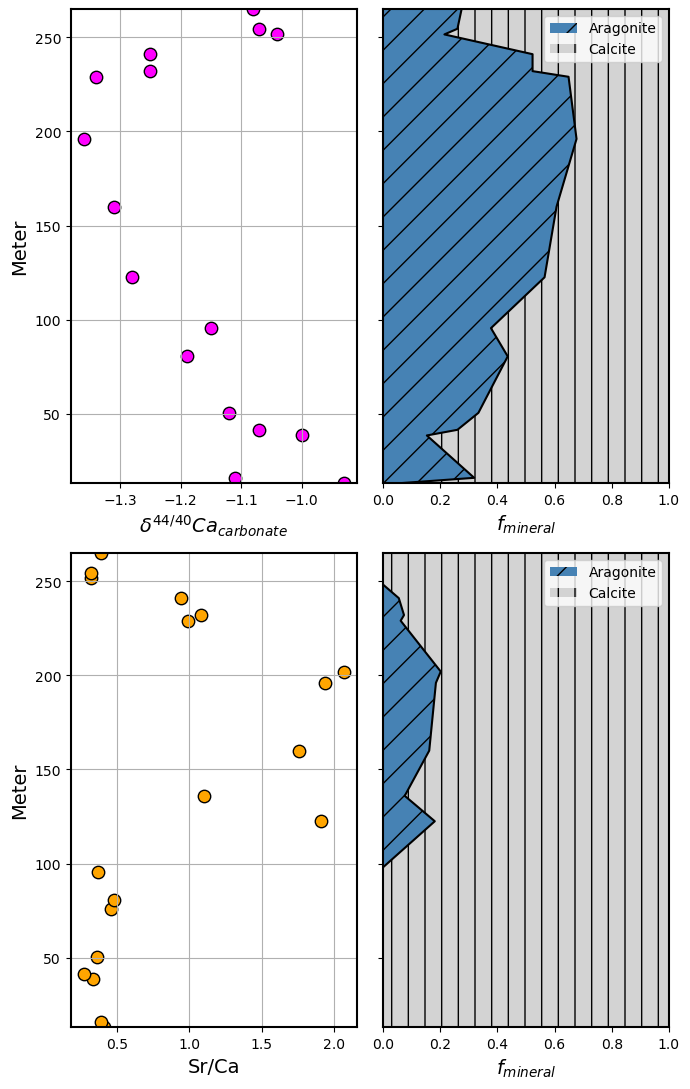

In [15]:
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2, 2, figsize=(7, 11), sharey=True)

ax1.set_ylim(meter_ca.min(), meter_ca.max())

ax1.scatter(d44Ca, meter_ca, ec='k', fc='magenta', s=80)
ax2.plot(frac_arag_ca, meter_ca, 'k-')
ax2.fill_betweenx(meter_ca, x1=0, x2=frac_arag_ca, label='Aragonite', 
                  fc='steelblue', hatch='/')
ax2.fill_betweenx(meter_ca, x1=frac_arag_ca, x2=1, label='Calcite',
                  fc='lightgrey', hatch='|')
ax2.legend()

ax3.scatter(SrCa_data, meter_srca, ec='k', fc='orange', s=80)
ax4.plot(frac_arag_srca, meter_srca, 'k-')
ax4.fill_betweenx(meter_srca, x1=0, x2=frac_arag_srca, label='Aragonite', 
                  fc='steelblue', hatch='/')
ax4.fill_betweenx(meter_srca, x1=frac_arag_srca, x2=1, label='Calcite',
                  fc='lightgrey', hatch='|')
ax4.legend()

ax1.set_xlabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax3.set_xlabel('Sr/Ca', fontsize=14)

for ax in (ax1, ax3):
    ax.set_ylabel('Meter', fontsize=14)
    ax.grid()

for ax in (ax2, ax4):
    ax.set_xlim(0,1)
    ax.set_xlabel('$f_{mineral}$', fontsize=14)

plt.tight_layout()
# plt.savefig('Figure/Aragonite_CalciteMixing_MineralFrac.png', dpi=300)
# plt.savefig('Figure/Aragonite_CalciteMixing_MineralFrac.svg')

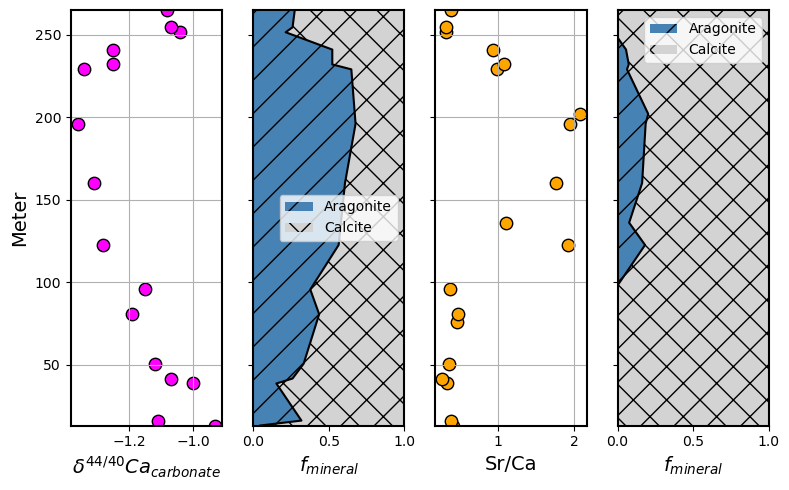

In [16]:
fig, (ax1, ax2, ax3, ax4)  = plt.subplots(1, 4, figsize=(8, 5), sharey=True)

ax1.set_ylim(meter_ca.min(), meter_ca.max())

ax1.scatter(d44Ca, meter_ca, ec='k', fc='magenta', s=80)
ax2.plot(frac_arag_ca, meter_ca, 'k-')
ax2.fill_betweenx(meter_ca, x1=0, x2=frac_arag_ca, label='Aragonite', 
                  fc='steelblue', hatch='/')
ax2.fill_betweenx(meter_ca, x1=frac_arag_ca, x2=1, label='Calcite',
                  fc='lightgrey', hatch='x')
ax2.legend()

ax3.scatter(SrCa_data, meter_srca, ec='k', fc='orange', s=80)
ax4.plot(frac_arag_srca, meter_srca, 'k-')
ax4.fill_betweenx(meter_srca, x1=0, x2=frac_arag_srca, label='Aragonite', 
                  fc='steelblue', hatch='/')
ax4.fill_betweenx(meter_srca, x1=frac_arag_srca, x2=1, label='Calcite',
                  fc='lightgrey', hatch='x')
ax4.legend()

ax1.set_xlabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax3.set_xlabel('Sr/Ca', fontsize=14)

ax1.set_ylabel('Meter', fontsize=14)
for ax in (ax1, ax3):
    ax.grid()

for ax in (ax2, ax4):
    ax.set_xlim(0,1)
    ax.set_xlabel('$f_{mineral}$', fontsize=14)

plt.tight_layout()

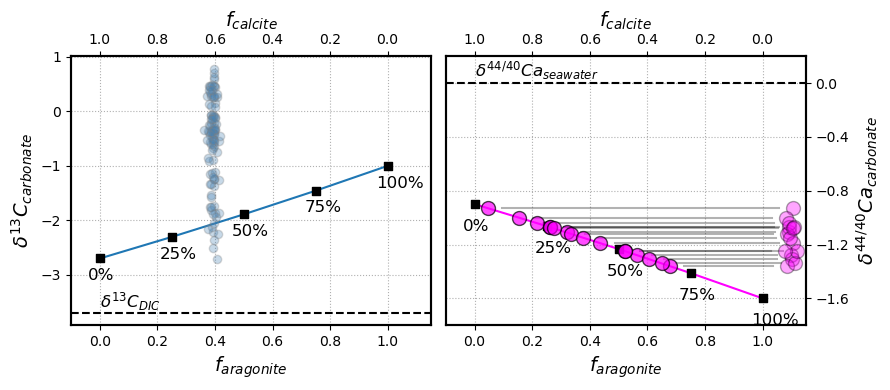

In [17]:
fig, (ax, ax1)  = plt.subplots(1, 2, figsize=(9, 4))


ax.plot(farg, isocarb)
ax.scatter(farg, isocarb, fc='k', marker='s', zorder=5)
ax.scatter(xdum1, d13C, fc='steelblue', ec='grey', alpha=0.3, zorder=6)
ax.axhline(y=-3.7, ls='--', c='k')
for i, j in zip(farg,isocarb):
    dx, dy = -0.04, -0.4
    ax.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)

ax.text(0, -3.6, '$\delta^{13}C_{DIC}$', fontsize=12)
ax.set_xlabel('$f_{aragonite}$', fontsize=14)
ax.set_ylabel('$\delta^{13}C_{carbonate}$', fontsize=14)
# ax.set_ylim(-0.4, 2.9)
ax.set_xlim(-0.1, 1.15)

axt = ax.twiny()
axt.set_xlim(1-(-0.1), 1-1.15)
axt.set_xlabel('$f_{calcite}$', fontsize=14)

# --------------
xdum2 = rng.normal(1.1, 0.01, len(d44Ca))

ax1.plot(farg, isoCacarb, c='magenta')
ax1.scatter(farg, isoCacarb, fc='k', marker='s', zorder=5)
ax1.scatter(frac_arag_ca, d44Ca, fc='magenta', ec='k', alpha=0.7, zorder=6, s=100)
ax1.scatter(xdum2, d44Ca, fc='magenta', ec='k', alpha=0.35, zorder=6, s=100)

for i in range(len(d44Ca)):
    ax1.plot([xdum2[i]-0.05, frac_arag_ca[i]+0.05], [d44Ca[i], d44Ca[i]], 'k-', alpha=0.3)


ax1.axhline(y=0, ls='--', c='k')
for i, j in zip(farg,isoCacarb):
    dx, dy = -0.04, -0.2
    ax1.text(i+dx, j+dy, '{:.0f}%'.format(i*100), fontsize=12)

ax1.text(0, 0.05, '$\delta^{44/40}Ca_{seawater}$', fontsize=12)
ax1.set_xlabel('$f_{aragonite}$', fontsize=14)
ax1.set_ylabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax1.set_ylim(-1.8, 0.2)
ax1.set_xlim(-0.1, 1.15)
ax1.tick_params(axis='y', left=False, right=True, labelleft=False,
                labelright=True)
ax1.yaxis.set_label_position('right')

axt1 = ax1.twiny()
axt1.set_xlim(1-(-0.1), 1-1.15)
axt1.set_xlabel('$f_{calcite}$', fontsize=14)

for axo in [ax, ax1]:
    axo.grid(which='both', linestyle=':')
    axo.yaxis.set_major_locator(plt.MaxNLocator(5))



plt.tight_layout()

In [18]:
# Translate mineralogic fraction to d13C
# Estimate the maximun influence of mineralogic fraction in causing excursion

farg_to_d13C = interp1d(farg, isocarb, bounds_error=False, fill_value='extrapolate')
d13C_from_min = farg_to_d13C(frac_arag_ca)

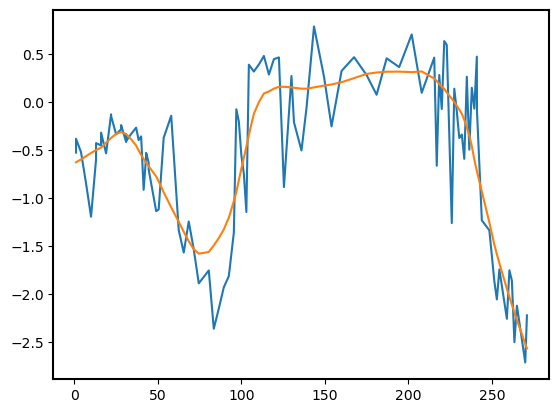

In [19]:
# d13C Lowess
d13c_lowess = lowess(d13C, meter_c, frac=0.2, return_sorted=False)
plt.plot(meter_c, d13C)
plt.plot(meter_c, d13c_lowess)

In [20]:
# Resample d13C from min
f = interp1d(meter_ca, d13C_from_min, bounds_error=False, fill_value=(-2.6, -2.2))

d13C_min_resampled = f(meter_c)

In [21]:
# Residual
d13C_Residual = d13c_lowess - d13C_min_resampled

In [22]:
# Calculate DIC
dic_evolve = d13C_Residual - 3.7

In [23]:
# Calculate DIC assuming no diagenesis

# resample aragonite fraction
f = interp1d(meter_ca, frac_arag_ca, bounds_error=False, fill_value=(0.05, 0.3))
frac_arag_ca_resampled = f(meter_c)

# Calcite fraction
frac_calc_ca_resampled = 1 - frac_arag_ca_resampled

# Calculate DIC
dic_assume_mineral = d13c_lowess - (2.7*frac_arag_ca_resampled) - (1*frac_calc_ca_resampled)

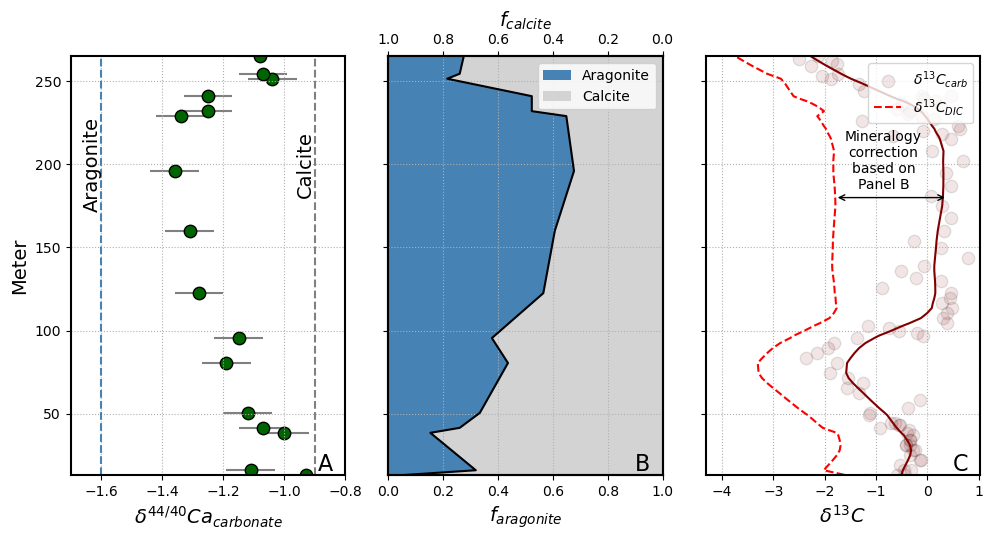

In [24]:
fig, (ax1, ax3, ax2) = plt.subplots(1,3, figsize=(10, 5.5), sharey=True)
ax1.set_ylim(meter_ca.min(), meter_ca.max())


ax1.scatter(d44Ca, meter_ca, ec='k', fc='darkgreen', s=80)
ax1.set_xlabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax1.errorbar(d44Ca, meter_ca, xerr=0.08, fmt='none', ecolor='gray',
            zorder=-2)

ax1.axvline(x=-1.6, ls='--', c='steelblue')
ax1.axvline(x=-0.9, ls='--', c='gray')
ax1.text(-1.63, 200, 'Aragonite', ha='center', va='center', rotation=90, fontsize=14)
ax1.text(-0.93, 200, 'Calcite', ha='center', va='center', rotation=90, fontsize=14)
ax1.set_xlim(-1.7, -0.8)


ax2.scatter(d13C, meter_c, ec='k', fc='maroon', s=80, alpha=0.1, 
            label='$\delta^{13}C_{carb}$')
# ax2.scatter(d13C_Residual, meter_c, ec='k', fc='maroon', s=80, 
#             label='$\delta^{13}C_{corrected}$')
# ax2.plot(dic_evolve, meter_c, 'r--', label='$\delta^{13}C_{DIC}$')
ax2.plot(dic_assume_mineral, meter_c, 'r--', label='$\delta^{13}C_{DIC}$')



ax2.plot( d13c_lowess, meter_c, c='maroon')
ax2.set_xlabel('$\delta^{13}C$', fontsize=14)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

ax3.plot(frac_arag_ca, meter_ca, 'k-')
ax3.fill_betweenx(meter_ca, x1=0, x2=frac_arag_ca, label='Aragonite', 
                  fc='steelblue')
ax3.fill_betweenx(meter_ca, x1=frac_arag_ca, x2=1, label='Calcite',
                  fc='lightgrey')
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax3.set_xlim(0,1)
ax3.set_xlabel('$f_{aragonite}$', fontsize=14)

ax3t = ax3.twiny()
ax3t.set_xlim(1,0)
ax3t.set_xlabel('$f_{calcite}$', fontsize=14)


ax1.set_ylabel('Meter', fontsize=14)

for axo, a in zip([ax1, ax2, ax3], ['A', 'C', 'B']):
    axo.grid(which='both', linestyle=':')
    axo.text(0.90, 0.01, a, transform=axo.transAxes, fontsize=16)


ax2.annotate("",
            xy=(-1.8, 180), xycoords='data',
            xytext=(0.4, 180), textcoords='data',
            arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))

ax2.text(-2+(0.3+2)/2, 185, 'Mineralogy\ncorrection\nbased on\nPanel B',
         ha='center', zorder=5)


plt.tight_layout()
# plt.savefig('Figure/d13C_Mineralogy_Corrected.png', dpi=300)
# plt.savefig('Figure/d13C_Mineralogy_Corrected.svg')

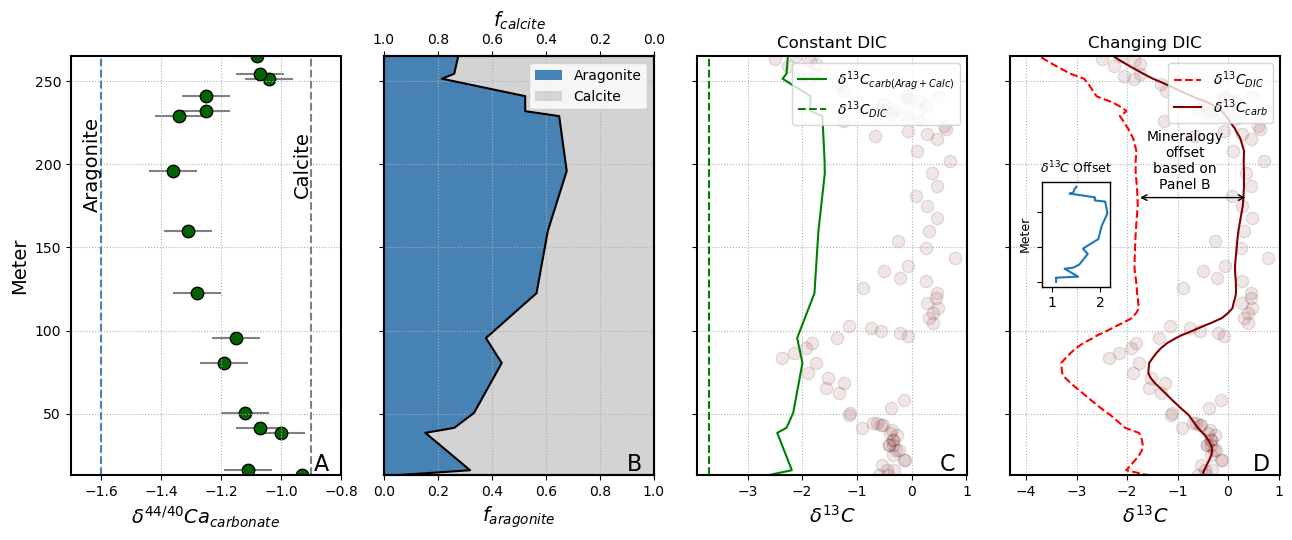

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(13, 5.5), sharey=True)

ax1.set_ylim(meter_ca.min(), meter_ca.max())


ax1.scatter(d44Ca, meter_ca, ec='k', fc='darkgreen', s=80)
ax1.set_xlabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax1.errorbar(d44Ca, meter_ca, xerr=0.08, fmt='none', ecolor='gray',
            zorder=-2)

ax1.axvline(x=-1.6, ls='--', c='steelblue')
ax1.axvline(x=-0.9, ls='--', c='gray')
ax1.text(-1.63, 200, 'Aragonite', ha='center', va='center', rotation=90, fontsize=14)
ax1.text(-0.93, 200, 'Calcite', ha='center', va='center', rotation=90, fontsize=14)
ax1.set_xlim(-1.7, -0.8)

ax1.set_ylabel('Meter', fontsize=14)

ax2.plot(frac_arag_ca, meter_ca, 'k-')
ax2.fill_betweenx(meter_ca, x1=0, x2=frac_arag_ca, label='Aragonite', 
                  fc='steelblue')
ax2.fill_betweenx(meter_ca, x1=frac_arag_ca, x2=1, label='Calcite',
                  fc='lightgrey')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax2.set_xlim(0,1)
ax2.set_xlabel('$f_{aragonite}$', fontsize=14)

ax2t = ax2.twiny()
ax2t.set_xlim(1,0)
ax2t.set_xlabel('$f_{calcite}$', fontsize=14)

ax3.scatter(d13C, meter_c, ec='k', fc='maroon', s=80, alpha=0.1)
ax3.plot(d13C_min_resampled, meter_c, '-', c='green', label='$\delta^{13}C_{carb(Arag+Calc)}$')
ax3.axvline(x=-3.7, c='green', ls='--', label='$\delta^{13}C_{DIC}$')
ax3.set_xlabel('$\delta^{13}C$', fontsize=14)
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax3.set_title('Constant DIC')

ax4.scatter(d13C, meter_c, ec='k', fc='maroon', s=80, alpha=0.1)
ax4.plot(dic_assume_mineral, meter_c, 'r--', label='$\delta^{13}C_{DIC}$')

ax4.plot( d13c_lowess, meter_c, c='maroon',
            label='$\delta^{13}C_{carb}$')
ax4.set_xlabel('$\delta^{13}C$', fontsize=14)
ax4.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax4.set_title('Changing DIC')



ax4.annotate("",
            xy=(-1.8, 180), xycoords='data',
            xytext=(0.4, 180), textcoords='data',
            arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))

ax4.text(-2+(0.3+2)/2, 185, 'Mineralogy\noffset\nbased on\nPanel B',
         ha='center', zorder=5)



fig.tight_layout()

cax = ax4.inset_axes([0.12, 0.45, 0.25, 0.25])
cax.plot(d13c_lowess - dic_assume_mineral, meter_c)
cax.set_title('$\delta^{13}C$ Offset', fontsize=9)
# cax.set_xlabel(' $\delta^{13}C$', fontsize=8)
cax.set_ylabel('Meter', fontsize=9)
cax.tick_params(labelleft=False)
cax.set_xlim(0.8, 2.2)

for axis in ['top','bottom','left','right']:
    cax.spines[axis].set_linewidth(1)

for axo, a in zip([ax1, ax2, ax3, ax4], ['A', 'B', 'C', 'D']):
    axo.grid(which='both', linestyle=':')
    axo.text(0.90, 0.01, a, transform=axo.transAxes, fontsize=16)

plt.savefig('Figure/d13C_Mineralogy_Corrected_new.png', dpi=300)
plt.savefig('Figure/d13C_Mineralogy_Corrected_new.svg')

In [26]:
# Degree and diagenesis style score
fludiag = pd.read_csv('Data/FluidDiag.csv')
fludiag = fludiag.dropna()

Text(0.5, 0, '% Diagenesis')

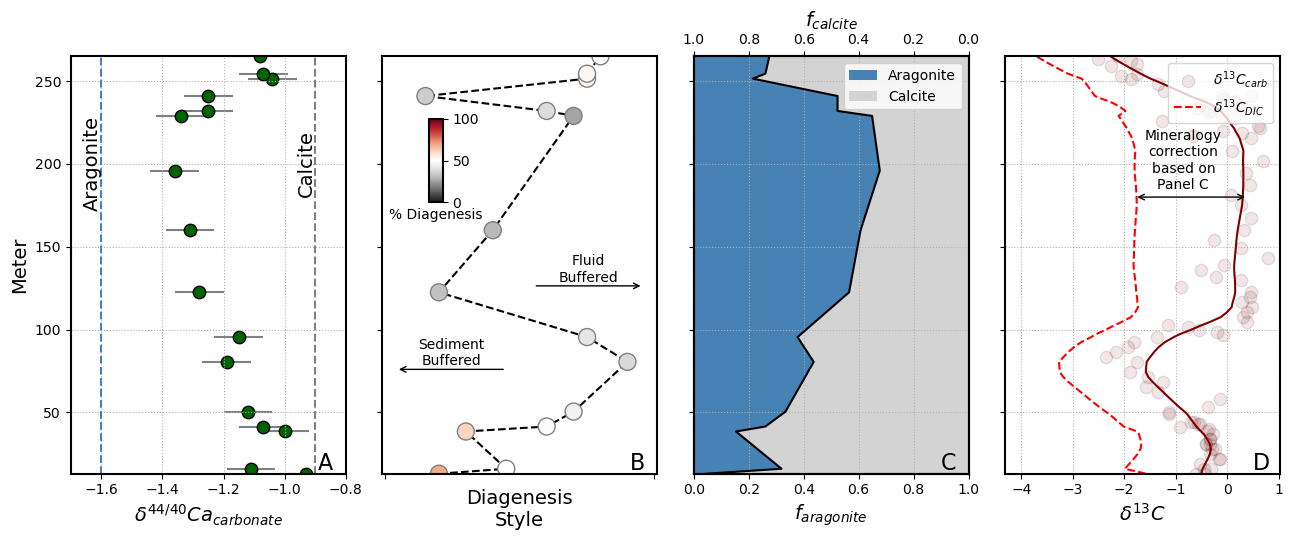

In [27]:
fig, (ax1, axt, ax3, ax2) = plt.subplots(1,4, figsize=(13, 5.5), sharey=True)
ax1.set_ylim(meter_ca.min(), meter_ca.max())


ax1.scatter(d44Ca, meter_ca, ec='k', fc='darkgreen', s=80)
ax1.set_xlabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax1.errorbar(d44Ca, meter_ca, xerr=0.08, fmt='none', ecolor='gray',
            zorder=-2)

ax1.axvline(x=-1.6, ls='--', c='steelblue')
ax1.axvline(x=-0.9, ls='--', c='gray')
ax1.text(-1.63, 200, 'Aragonite', ha='center', va='center', rotation=90, fontsize=14)
ax1.text(-0.93, 200, 'Calcite', ha='center', va='center', rotation=90, fontsize=14)
ax1.set_xlim(-1.7, -0.8)

axt.plot(fludiag['fluid_diag'], fludiag['Meter'], 'k--')
mplot = axt.scatter(fludiag['fluid_diag'], fludiag['Meter'], s=150, ec='gray',
            c=fludiag['alter'], zorder=2, cmap='RdGy_r', vmin=0, vmax=100)
axt.set_xlim(0-0.01, 1+0.01)
axt.set_xticks([0, 1], labels=[])
axt.set_xlabel('Diagenesis\nStyle', fontsize=14)



ax2.scatter(d13C, meter_c, ec='k', fc='maroon', s=80, alpha=0.1, 
            label='$\delta^{13}C_{carb}$')
# ax2.scatter(d13C_Residual, meter_c, ec='k', fc='maroon', s=80, 
#             label='$\delta^{13}C_{corrected}$')
ax2.plot(dic_evolve, meter_c, 'r--', label='$\delta^{13}C_{DIC}$')


ax2.plot( d13c_lowess, meter_c, c='maroon')
ax2.set_xlabel('$\delta^{13}C$', fontsize=14)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

ax3.plot(frac_arag_ca, meter_ca, 'k-')
ax3.fill_betweenx(meter_ca, x1=0, x2=frac_arag_ca, label='Aragonite', 
                  fc='steelblue')
ax3.fill_betweenx(meter_ca, x1=frac_arag_ca, x2=1, label='Calcite',
                  fc='lightgrey')
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax3.set_xlim(0,1)
ax3.set_xlabel('$f_{aragonite}$', fontsize=14)

ax3t = ax3.twiny()
ax3t.set_xlim(1,0)
ax3t.set_xlabel('$f_{calcite}$', fontsize=14)


ax1.set_ylabel('Meter', fontsize=14)

for axo, a in zip([ax1, axt, ax2, ax3], ['A', 'B','D', 'C']):
    if axo != axt:
        axo.grid(which='both', linestyle=':')

    axo.text(0.90, 0.01, a, transform=axo.transAxes, fontsize=16)


ax2.annotate("",
            xy=(-1.8, 180), xycoords='data',
            xytext=(0.4, 180), textcoords='data',
            arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))

ax2.text(-2+(0.3+2)/2, 185, 'Mineralogy\ncorrection\nbased on\nPanel C',
         ha='center', zorder=5)

axt.annotate("",
            xy=(0.05, 0.25), xycoords='axes fraction',
            xytext=(0.45, 0.25), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

axt.text(0.25, 0.26,'Sediment\nBuffered', transform=axt.transAxes, ha='center')

axt.annotate("",
            xy=(0.55, 0.45), xycoords='axes fraction',
            xytext=(0.95, 0.45), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="<-", connectionstyle="arc3"))
axt.text(0.75, 0.46,'Fluid\nBuffered', transform=axt.transAxes, ha='center')

plt.tight_layout()

cax = axt.inset_axes([0.17, 0.65, 0.05, 0.2])
# Add colorbar
cbar = fig.colorbar(mplot, cax=cax)
cbar.ax.set_xlabel('% Diagenesis', fontsize=10)
# plt.savefig('Figure/d13C_Mineralogy_Corrected_DiagStyle.png', dpi=300)
# plt.savefig('Figure/d13C_Mineralogy_Corrected_DiagStyle.svg')

Text(0.5, 0, '% Diagenesis')

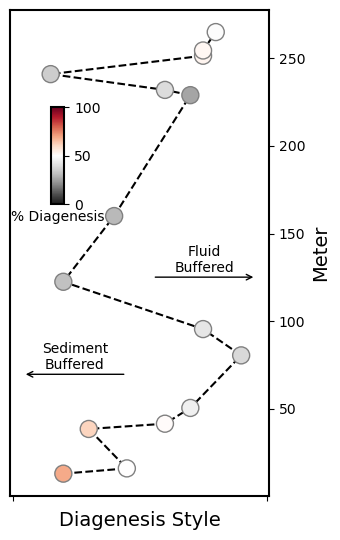

In [28]:
fig, axt = plt.subplots(1,1, figsize=(3.5, 5.5))

axt.plot(fludiag['fluid_diag'], fludiag['Meter'], 'k--')
mplot = axt.scatter(fludiag['fluid_diag'], fludiag['Meter'], s=150, ec='gray',
            c=fludiag['alter'], zorder=2, cmap='RdGy_r', vmin=0, vmax=100)
axt.set_xlim(0-0.01, 1+0.01)
axt.set_xticks([0, 1], labels=[])
axt.set_xlabel('Diagenesis Style', fontsize=14)
axt.set_ylabel('Meter', fontsize=14)

axt.tick_params(axis='y', left=False, right=True, labelleft=False,
                labelright=True)
axt.yaxis.set_label_position('right')

axt.annotate("",
            xy=(0.05, 0.25), xycoords='axes fraction',
            xytext=(0.45, 0.25), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

axt.text(0.25, 0.26,'Sediment\nBuffered', transform=axt.transAxes, ha='center')

axt.annotate("",
            xy=(0.55, 0.45), xycoords='axes fraction',
            xytext=(0.95, 0.45), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="<-", connectionstyle="arc3"))
axt.text(0.75, 0.46,'Fluid\nBuffered', transform=axt.transAxes, ha='center')

plt.tight_layout()

cax = axt.inset_axes([0.16, 0.6, 0.05, 0.2])
# Add colorbar
cbar = fig.colorbar(mplot, cax=cax)
cbar.ax.set_xlabel('% Diagenesis', fontsize=10)

# plt.savefig('Figure/DiagStyle.png', dpi=300)
# plt.savefig('Figure/DiagStyle.svg')

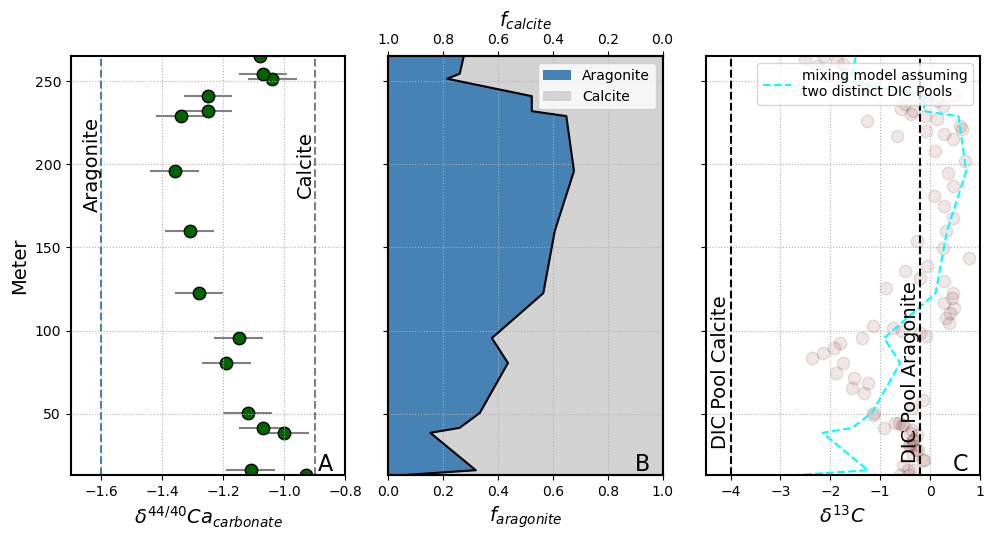

In [42]:
arag_d13C = 2.5
calc_d13C = -3

mix_d13C = frac_arag_ca*arag_d13C + (1 - frac_arag_ca)*calc_d13C



fig, (ax1, ax3, ax2) = plt.subplots(1,3, figsize=(10, 5.5), sharey=True)
ax1.set_ylim(meter_ca.min(), meter_ca.max())


ax1.scatter(d44Ca, meter_ca, ec='k', fc='darkgreen', s=80)
ax1.set_xlabel('$\delta^{44/40}Ca_{carbonate}$', fontsize=14)
ax1.errorbar(d44Ca, meter_ca, xerr=0.08, fmt='none', ecolor='gray',
            zorder=-2)

ax1.axvline(x=-1.6, ls='--', c='steelblue')
ax1.axvline(x=-0.9, ls='--', c='gray')
ax1.text(-1.63, 200, 'Aragonite', ha='center', va='center', rotation=90, fontsize=14)
ax1.text(-0.93, 200, 'Calcite', ha='center', va='center', rotation=90, fontsize=14)
ax1.set_xlim(-1.7, -0.8)


ax2.scatter(d13C, meter_c, ec='k', fc='maroon', s=80, alpha=0.1)
ax2.plot(mix_d13C, meter_ca, ls='--', c='cyan', label='mixing model assuming\ntwo distinct DIC Pools')

ax2.set_xlabel('$\delta^{13}C$', fontsize=14)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax2.axvline(x=arag_d13C-2.7, ls='--', c='k')
ax2.axvline(x=calc_d13C-1, ls='--', c='k')

ax2.text(arag_d13C-2.7 - 0.2, 75, 'DIC Pool Aragonite', ha='center', va='center', rotation=90, fontsize=14)
ax2.text(calc_d13C-1 - 0.2, 75, 'DIC Pool Calcite', ha='center', va='center', rotation=90, fontsize=14)
ax2.set_xlim(-4.5, 1)

ax3.plot(frac_arag_ca, meter_ca, 'k-')
ax3.fill_betweenx(meter_ca, x1=0, x2=frac_arag_ca, label='Aragonite', 
                  fc='steelblue')
ax3.fill_betweenx(meter_ca, x1=frac_arag_ca, x2=1, label='Calcite',
                  fc='lightgrey')
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax3.set_xlim(0,1)
ax3.set_xlabel('$f_{aragonite}$', fontsize=14)

ax3t = ax3.twiny()
ax3t.set_xlim(1,0)
ax3t.set_xlabel('$f_{calcite}$', fontsize=14)


ax1.set_ylabel('Meter', fontsize=14)

for axo, a in zip([ax1, ax2, ax3], ['A', 'C', 'B']):
    axo.grid(which='both', linestyle=':')
    axo.text(0.90, 0.01, a, transform=axo.transAxes, fontsize=16)




plt.tight_layout()
plt.savefig('Figure/Min_Mixing_TwoPools.png', dpi=300)